# QC filtering

This notebook is about filtering scATAC seq data within an adata object to archive a good quality peak matrix.
For this task various QC filters are implemented. The latter includes filters related to:

- doublet score
- number of features per barcode
- mean insert size
- promotor enrichment


## Settings

In [15]:
#Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/ext_ana/processed'
test = 'sample1'

## QC Settings

In [16]:
# Set the column in adata.obs containing the biological condition to evaluate
condition_column = "sample"

# Data inspection
# Set True if the insertsize distribution should be plotted
# If there is no insertsize distribution set this False
plot_insertsize_dist = True

filter_xy = True  # True or False; filtering out chrX and chrY
binarize_mtx = True  # True or False; convert matrix to binary
select_hvf = True  # True or False; select only highly variable features

# Highly Variable Features thresholds:
min_limit = 1000
max_limit = 5000

############################# filters ##########################################

# Decide whether to estimate thresholds individual per condition (False) or globally (True)
global_threshold = True

# Filter to use:
n_features_filter = True # True or False; filtering out cells with numbers of features not in the range defined below
mean_insertsize_filter = True # True or False; filtering out cells with mean insertsize not in the range defined below
filter_pct_fp= False # True or False; filtering out cells with promotor_enrichment not in the range defined below
filter_n_fragments= False # True or False; filtering out cells with promotor_enrichment not in the range defined below
filter_chrM_fragments= False # True or False; filtering out cells with promotor_enrichment not in the range defined below
filter_uniquely_mapped_fragments= False # True or False; filtering out cells with promotor_enrichment not in the range defined


# if this is True thresholds below are ignored 
only_automatic_thresholds = False # True or False; to use automatic thresholds

############################# set default values #######################################
# 
# This will be applied to all samples the thresholds can be changed manually when plotted 
# if thresholds None they are set automatically

# default values n_features 
min_features = 100
max_features = 5000

# default mean_insertsize
upper_threshold_mis=None
lower_threshold_mis=None

# default promotor enrichment
upper_threshold_pct_fp=None
lower_threshold_pct_fp=None

# default number of fragments
upper_thr_fragments=None
lower_thr_fragments=None

# default number of fragments in chrM
upper_thr_chrM_fragments=1000
lower_thr_chrM_fragments=0

# default number of uniquely mapped fragments
upper_thr_um=20000
lower_thr_um=0



## Sum up settings

In [17]:
manual_thresholds = {}
if n_features_filter:
    manual_thresholds['n_features_by_counts'] = {'min' : min_features, 'max' : max_features}

if mean_insertsize_filter:
    manual_thresholds['mean_insertsize'] = {'min' : lower_threshold_mis, 'max' : upper_threshold_mis}

if filter_pct_fp:
    manual_thresholds['pct_fragments_in_promoters'] = {'min' : lower_threshold_pct_fp, 'max' : upper_threshold_pct_fp}

if filter_n_fragments:
    manual_thresholds['TN'] = {'min' : lower_thr_fragments, 'max' : upper_thr_fragments}

if filter_chrM_fragments:
    manual_thresholds['CM'] = {'min' : lower_thr_chrM_fragments, 'max' : upper_thr_chrM_fragments}

if filter_uniquely_mapped_fragments:
    manual_thresholds['UM'] = {'min' : lower_thr_um, 'max' : upper_thr_um}

obs_columns = list(manual_thresholds.keys())

## Loading packages and setup

In [18]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.annotation as an
from sctoolbox.qc_filter import *
from sctoolbox.plotting import *
from sctoolbox.atac_utils import *
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
import numpy as np

## Setup path handling object 

In [19]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [20]:
# probably updated in future
assembling_output = tree.assembled_anndata
adata = epi.read_h5ad(assembling_output)
adata

AnnData object with n_obs × n_vars = 8371 × 148517
    obs: 'chr1_reads', 'chr10_reads', 'chr11_reads', 'chr12_reads', 'chr13_reads', 'chr14_reads', 'chr15_reads', 'chr16_reads', 'chr17_reads', 'chr18_reads', 'chr19_reads', 'chr2_reads', 'chr3_reads', 'chr4_reads', 'chr5_reads', 'chr6_reads', 'chr7_reads', 'chr8_reads', 'chr9_reads', 'chrM_reads', 'chrX_reads', 'chrY_reads', 'total_genome_reads', 'insertsize_mean', 'Sample', 'id', 'condition', 'date', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize'
    var: 'peak_chr', 'peak_start', 'peak_end', 'peak_id', 'peak_score', 'peak_strand', 'feature', 'gene_start', 'gene_end', 'gene_strand', 'gene_anchor', 'distance_to_gene', 'relative_location_to_gene', 'gene_ovl_peak', 'peak_ovl_gene', 'gene_biotype', 'gene_id', 'gene_name', 'annotation_query', 'region_length', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 

In [21]:
adata.var 

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,...,gene_id,gene_name,annotation_query,region_length,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
annotated_peaks_0_chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,374,22,0.005017,0.005005,99.737188,42.0,3.761200
annotated_peaks_100000_chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,...,ENSMUSG00000028795,Ccdc28b,protein_coding_promoter,477,995,0.282404,0.248736,88.113726,2364.0,7.768533
annotated_peaks_100001_chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,...,ENSMUSG00000028795,Ccdc28b,protein_coding_promoter,285,211,0.052323,0.051001,97.479393,438.0,6.084499
annotated_peaks_100002_chr4:129527627-129527883,chr4,129527627,129527883,peak_100003,.,.,gene,129519870.0,129534858.0,-,...,ENSMUSG00000053841,Txlna,protein_coding_internal,256,37,0.008601,0.008564,99.557998,72.0,4.290460
annotated_peaks_100003_chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,...,ENSMUSG00000053841,Txlna,protein_coding_promoter,233,113,0.025326,0.025010,98.650102,212.0,5.361292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
annotated_peaks_99999_chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,...,ENSMUSG00000028795,Ccdc28b,protein_coding_promoter,266,246,0.055668,0.054174,97.061283,466.0,6.146329
annotated_peaks_9999_chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,...,ENSMUSG00000037375,Hhat,protein_coding_distal,247,80,0.019472,0.019285,99.044320,163.0,5.099866
annotated_peaks_999_chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,...,ENSMUSG00000050122,Vwa3b,protein_coding_distal,402,52,0.012782,0.012701,99.378808,107.0,4.682131
annotated_peaks_99_chr1:7849890-7850111,chr1,7849890,7850111,peak_100,.,.,gene,7799084.0,7800789.0,-,...,ENSMUSG00000103557,Gm38216,any_gene_distal,221,15,0.003106,0.003101,99.820810,26.0,3.295837


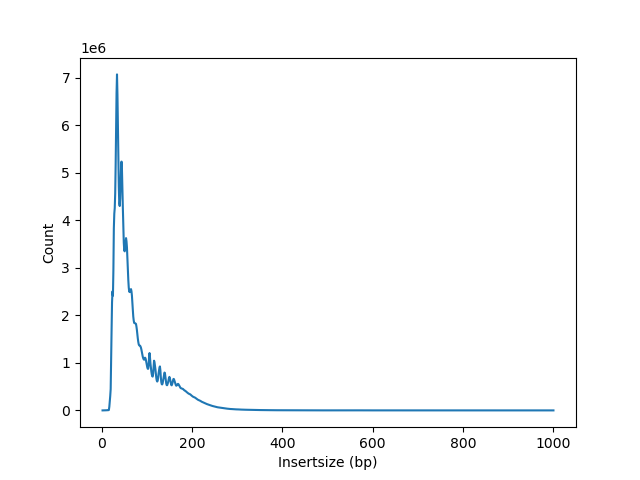

In [22]:
if plot_insertsize_dist:
    atac.plot_insertsize(adata)

# QC

## 1. filtering out chrX, chrY and chrM

In [23]:
non_m = [name for name in adata.var_names if not name.startswith('chrM')]  # remove chrM
adata = adata[:, non_m]

In [24]:
if filter_xy:
    non_xy = [name for name in adata.var_names if not name.startswith('chrY') | name.startswith('chrX')]
    adata = adata[:, non_xy]

In [25]:
display(adata)

View of AnnData object with n_obs × n_vars = 8371 × 148517
    obs: 'chr1_reads', 'chr10_reads', 'chr11_reads', 'chr12_reads', 'chr13_reads', 'chr14_reads', 'chr15_reads', 'chr16_reads', 'chr17_reads', 'chr18_reads', 'chr19_reads', 'chr2_reads', 'chr3_reads', 'chr4_reads', 'chr5_reads', 'chr6_reads', 'chr7_reads', 'chr8_reads', 'chr9_reads', 'chrM_reads', 'chrX_reads', 'chrY_reads', 'total_genome_reads', 'insertsize_mean', 'Sample', 'id', 'condition', 'date', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize'
    var: 'peak_chr', 'peak_start', 'peak_end', 'peak_id', 'peak_score', 'peak_strand', 'feature', 'gene_start', 'gene_end', 'gene_strand', 'gene_anchor', 'distance_to_gene', 'relative_location_to_gene', 'gene_ovl_peak', 'peak_ovl_gene', 'gene_biotype', 'gene_id', 'gene_name', 'annotation_query', 'region_length', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_c

## 2. removing empty cells

In [26]:
epi.pp.filter_cells(adata, min_features=1)
# log-convert number of features
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
display(adata)

AnnData object with n_obs × n_vars = 8371 × 148517
    obs: 'chr1_reads', 'chr10_reads', 'chr11_reads', 'chr12_reads', 'chr13_reads', 'chr14_reads', 'chr15_reads', 'chr16_reads', 'chr17_reads', 'chr18_reads', 'chr19_reads', 'chr2_reads', 'chr3_reads', 'chr4_reads', 'chr5_reads', 'chr6_reads', 'chr7_reads', 'chr8_reads', 'chr9_reads', 'chrM_reads', 'chrX_reads', 'chrY_reads', 'total_genome_reads', 'insertsize_mean', 'Sample', 'id', 'condition', 'date', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'nb_features', 'log_nb_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'peak_id', 'peak_score', 'peak_strand', 'feature', 'gene_start', 'gene_end', 'gene_strand', 'gene_anchor', 'distance_to_gene', 'relative_location_to_gene', 'gene_ovl_peak', 'peak_ovl_gene', 'gene_biotype', 'gene_id', 'gene_name', 'annotation_query', 'region_length', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_

## 3. binarize

In [27]:
adata.raw = adata
if binarize_mtx:
    epi.pp.binarize(adata)
    adata.layers['binary'] = adata.X.copy()

## 5. visualize adata

In [30]:
adata.var

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,...,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,commonness,n_cells,prop_shared_cells,variability_score
annotated_peaks_0_chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,...,22,0.005017,0.005005,99.737188,42.0,3.761200,22.0,22.0,0.002628,0.502628
annotated_peaks_100000_chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,...,995,0.282404,0.248736,88.113726,2364.0,7.768533,995.0,995.0,0.118863,0.618863
annotated_peaks_100001_chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,...,211,0.052323,0.051001,97.479393,438.0,6.084499,211.0,211.0,0.025206,0.525206
annotated_peaks_100002_chr4:129527627-129527883,chr4,129527627,129527883,peak_100003,.,.,gene,129519870.0,129534858.0,-,...,37,0.008601,0.008564,99.557998,72.0,4.290460,37.0,37.0,0.004420,0.504420
annotated_peaks_100003_chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,...,113,0.025326,0.025010,98.650102,212.0,5.361292,113.0,113.0,0.013499,0.513499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
annotated_peaks_99999_chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,...,246,0.055668,0.054174,97.061283,466.0,6.146329,246.0,246.0,0.029387,0.529387
annotated_peaks_9999_chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,...,80,0.019472,0.019285,99.044320,163.0,5.099866,80.0,80.0,0.009557,0.509557
annotated_peaks_999_chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,...,52,0.012782,0.012701,99.378808,107.0,4.682131,52.0,52.0,0.006212,0.506212
annotated_peaks_99_chr1:7849890-7850111,chr1,7849890,7850111,peak_100,.,.,gene,7799084.0,7800789.0,-,...,15,0.003106,0.003101,99.820810,26.0,3.295837,15.0,15.0,0.001792,0.501792


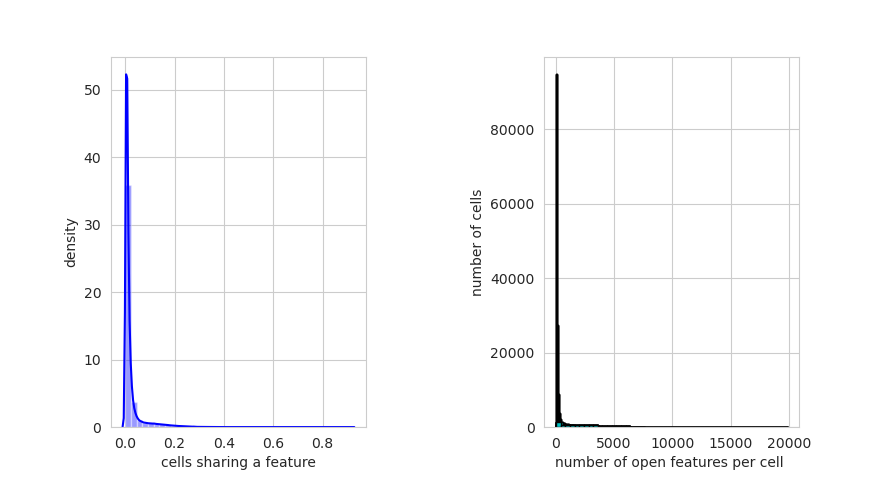

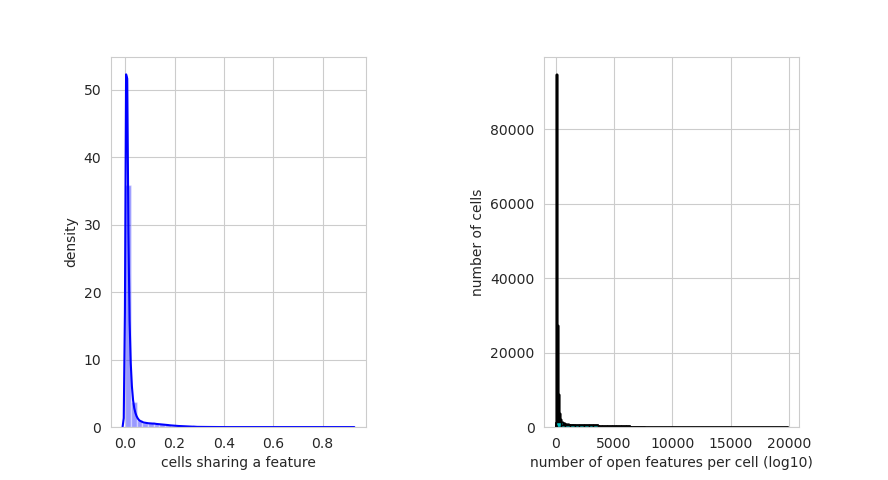

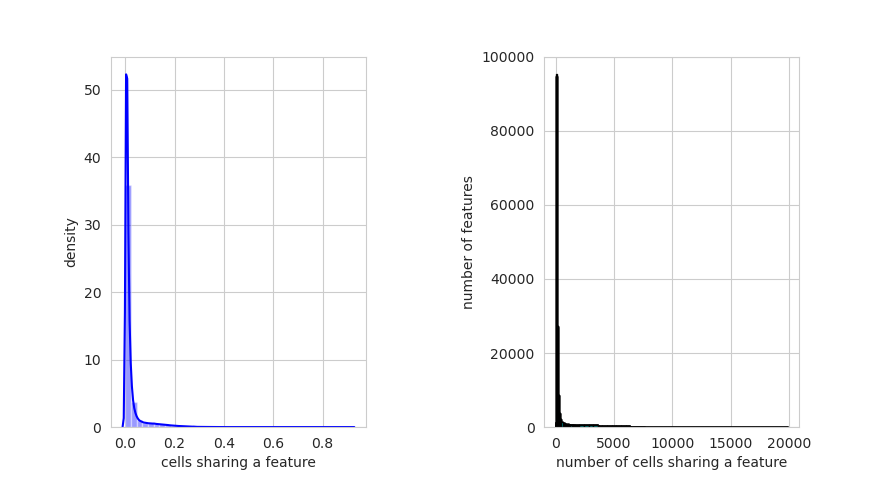

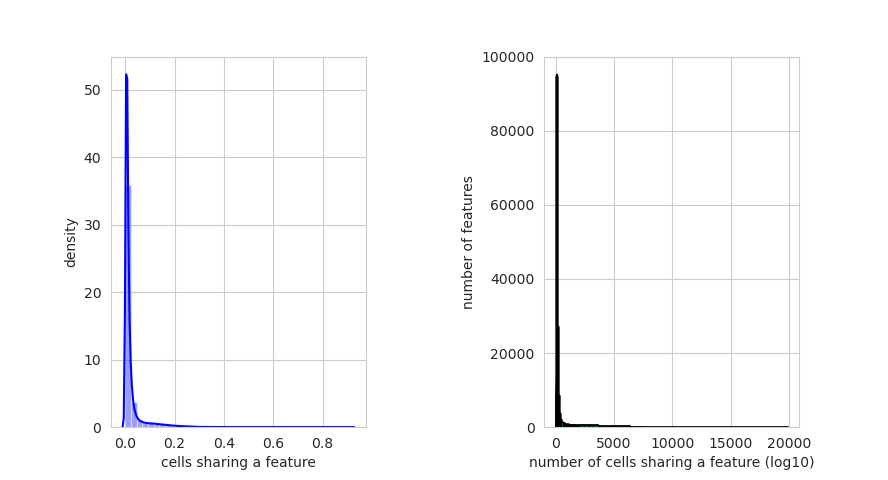

In [40]:
# plot_ov_hist(adata, threshold_features=50) # FIXME: Later plots do not visualize
epi.pp.filter_features(adata, min_cells=1)
epi.pp.filter_cells(adata, min_features=1)
epi.pp.coverage_cells(adata, binary=True, log=False, bins=50)
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50)

epi.pp.coverage_features(adata, binary=True, log=False, bins=50)
epi.pp.coverage_features(adata, binary=True, log=10, bins=50)

## 6. Cells Filtering

### 6.1 get thresholds dict

In [15]:
groupby = condition_column if global_threshold is False else None
default_thresholds = build_default_thresholds(adata, manual_thresholds, groupby)
default_thresholds

{'n_features_by_counts': {'min': 100, 'max': 5000},
 'mean_insertsize': {'min': None, 'max': None}}

In [16]:
thresholds = get_thresholds_atac_wrapper(adata, default_thresholds, only_automatic_thresholds, groupby=None)
thresholds_as_table(thresholds)

,Parameter,Minimum,Maximum
0,n_features_by_counts,100.000000,5000.000000
1,mean_insertsize,43.205931,109.708942


### 6.2 plot thresholds

In [13]:
%matplotlib widget
%bgcolor PowderBlue

#Plot violins and sliders
obs_figure, obs_slider_dict = quality_violin(adata, columns=obs_columns,
                                            groupby=condition_column,
                                            which="obs",
                                            thresholds=thresholds,
                                            global_threshold=global_threshold,
                                            title="Cell quality control (before)",
                                            save=tree.qc_plots + "cell_filtering.png")
obs_figure

NameError: name 'thresholds' is not defined

In [14]:
# Get final thresholds
final_thresholds = get_slider_thresholds(obs_slider_dict)
thresholds_as_table(final_thresholds) # show thresholds

NameError: name 'obs_slider_dict' is not defined

### 6.3 filter adata

In [19]:
apply_qc_thresholds(adata, final_thresholds)
# remove empty features
epi.pp.filter_features(adata, min_cells=1)

Filtering based on 'n_features_by_counts' from 8371 -> 6298 cells
Filtering based on 'mean_insertsize' from 6298 -> 6249 cells


### remove empty features

In [20]:

# log-convert number of features
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
display(adata)

AnnData object with n_obs × n_vars = 6249 × 118387
    obs: 'chr1_reads', 'chr10_reads', 'chr11_reads', 'chr12_reads', 'chr13_reads', 'chr14_reads', 'chr15_reads', 'chr16_reads', 'chr17_reads', 'chr18_reads', 'chr19_reads', 'chr2_reads', 'chr3_reads', 'chr4_reads', 'chr5_reads', 'chr6_reads', 'chr7_reads', 'chr8_reads', 'chr9_reads', 'chrM_reads', 'chrX_reads', 'chrY_reads', 'total_genome_reads', 'insertsize_mean', 'Sample', 'id', 'condition', 'date', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'nb_features', 'log_nb_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'peak_id', 'peak_score', 'peak_strand', 'feature', 'gene_start', 'gene_end', 'gene_strand', 'gene_anchor', 'distance_to_gene', 'relative_location_to_gene', 'gene_ovl_peak', 'peak_ovl_gene', 'gene_biotype', 'gene_id', 'gene_name', 'annotation_query', 'region_length', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_

## 7. save plots

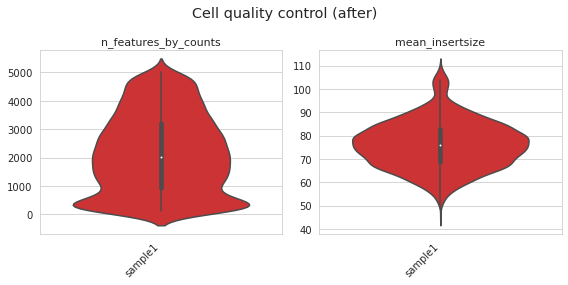

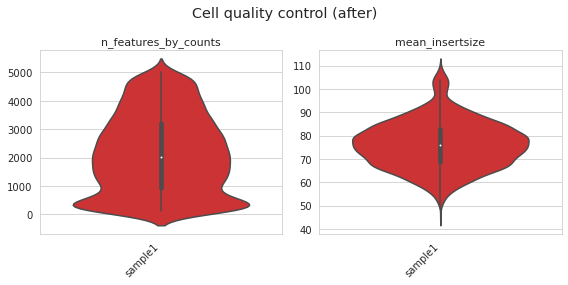

In [21]:
%matplotlib inline 

#Plot violins and sliders
figure, slider_dict = quality_violin(adata, columns=obs_columns,
                                     groupby=condition_column,
                                     which="obs", ncols=3,
                                     global_threshold = global_threshold,
                                     title="Cell quality control (after)",
                                     save=tree.qc_plots + "cell_filtering_final.png")
figure 

## 8. save anndata

In [22]:
adata.obs

,chr1_reads,chr10_reads,chr11_reads,chr12_reads,chr13_reads,chr14_reads,chr15_reads,chr16_reads,chr17_reads,chr18_reads,...,file,sample,n_features_by_counts,log1p_n_features_by_counts,total_counts,log1p_total_counts,insertsize_count,mean_insertsize,nb_features,log_nb_features
barcode,,,,,,,,,,,,,,,,,,,,,
CCATGATGAATCTGTG-sample1,5930,5367,657,2109,14960,3999,15397,6899,4282,6064,...,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,2172,7.683864,6863.0,8.834045,162317,70.24,2168.0,3.336860
TGTTATCACGCTAGAG-sample1,4786,4055,3375,4053,3294,3010,3192,2737,3509,2867,...,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,3766,8.234034,8689.0,9.069928,99597,80.60,3765.0,3.575880
GAACTACTGTATTGCG-sample1,1564,612,2039,2309,1834,2987,1444,907,1517,1515,...,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,401,5.996452,973.0,6.881412,77228,76.57,401.0,2.603144
TACCGACCTCGAACGA-sample1,4176,3330,2550,2547,2076,2622,1893,2194,1571,1546,...,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,4784,8.473241,13658.0,9.522154,91682,85.62,4784.0,3.679791
TGAATGGCTTAGGAGC-sample1,1981,1118,899,627,885,971,1104,850,830,525,...,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,3565,8.179200,8785.0,9.080914,34002,91.16,3565.0,3.552060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TATTCAGCTTGGAACG-sample1,50,55,88,28,48,40,86,42,48,32,...,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,276,5.624018,549.0,6.309918,1262,75.84,276.0,2.440909
CCTGCCTCTAGCGCTC-sample1,44,58,66,34,42,34,38,28,54,24,...,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,285,5.655992,574.0,6.354370,1044,78.24,285.0,2.454845
TGGTTAGACACACAAA-sample1,46,100,58,36,44,22,26,32,54,34,...,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,168,5.129899,338.0,5.826000,902,61.49,168.0,2.225309


In [23]:
adata.var

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,...,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,commonness,prop_shared_cells,variability_score
annotated_peaks_0_chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,...,22,0.005017,0.005005,99.737188,42.0,3.761200,15,22.0,0.002628,0.502628
annotated_peaks_100000_chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,...,995,0.282404,0.248736,88.113726,2364.0,7.768533,537,995.0,0.118863,0.618863
annotated_peaks_100001_chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,...,211,0.052323,0.051001,97.479393,438.0,6.084499,119,211.0,0.025206,0.525206
annotated_peaks_100003_chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,...,113,0.025326,0.025010,98.650102,212.0,5.361292,38,113.0,0.013499,0.513499
annotated_peaks_100004_chr4:129534299-129535110,chr4,129534299,129535110,peak_100005,.,.,gene,129519870.0,129534858.0,-,...,1202,0.364592,0.310856,85.640903,3052.0,8.023880,643,1202.0,0.143591,0.643591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
annotated_peaks_99998_chr4:129515107-129515508,chr4,129515107,129515508,peak_99999,.,.,gene,129508918.0,129512892.0,-,...,322,0.084817,0.081411,96.153387,710.0,6.566672,162,322.0,0.038466,0.538466
annotated_peaks_99999_chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,...,246,0.055668,0.054174,97.061283,466.0,6.146329,119,246.0,0.029387,0.529387
annotated_peaks_9999_chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,...,80,0.019472,0.019285,99.044320,163.0,5.099866,45,80.0,0.009557,0.509557
annotated_peaks_999_chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,...,52,0.012782,0.012701,99.378808,107.0,4.682131,26,52.0,0.006212,0.506212


In [24]:
adata_output = tree.qc_anndata
adata.write(filename=adata_output)